# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = '/datasets/faces/'

In [3]:
df = pd.read_csv(path+'labels.csv')
datagen = ImageDataGenerator(rescale=1/255)

data = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = path+'final_files', 
    x_col = 'file_name', 
    y_col = 'real_age', 
    class_mode = 'raw', 
    batch_size = 16,
    seed = 42)

Found 7591 validated image filenames.


In [4]:
features, target = next(data)
print('В выборке {:} изображений размера {:}x{:} пикселей с {:} каналами'.format(
    df.shape[0], features.shape[1], features.shape[2], features.shape[3]))

В выборке 7591 изображений размера 256x256 пикселей с 3 каналами


Так распредилились возраста:

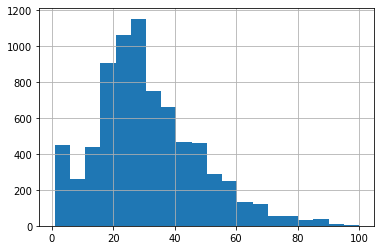

In [5]:
df['real_age'].hist(bins=20);

Посмотрим на состав датасета:

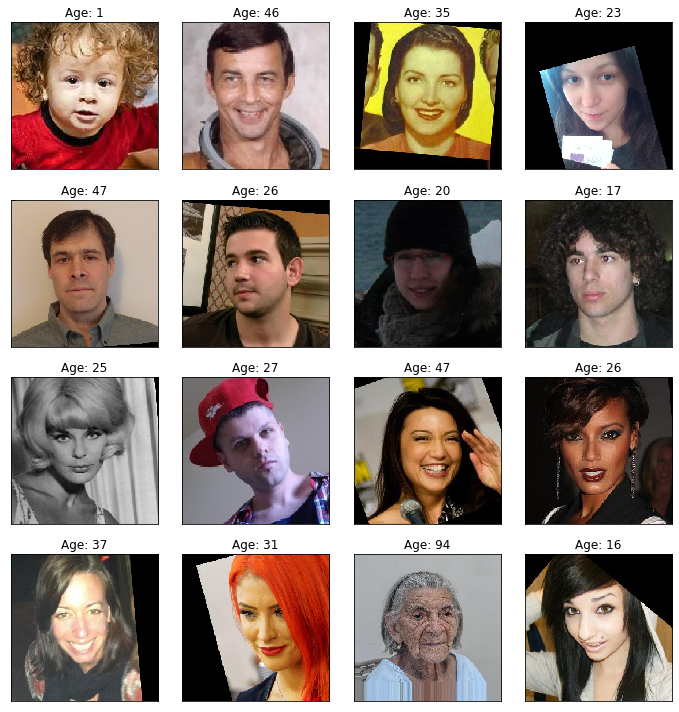

In [6]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title('Age: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете представлены лица людей под разными углами с указанием возраста. Некоторые картинки обрезаны или находятся под углом. Изображения имеют разную яркость, также есть черно-белые фотографии и старые отсканированные фотографии. Т.к. модель разрабатывается для работы с камерой видеонаблюдения в магазине, то лучше не обучать модель на чёрно-белых фотографиях, если камера будет цветной. А при использовании черно-белой камеры нужно сделать все фото черно-белыми. Также стоит добавить аугментацию по якросит и небольшому углу.

## Выводы:
В выборке 7591 изображений размера 256x256 пикселей с 3 каналами, возраста распределены не равномерно. Некоторые изображения наклонены. Для лучшего обучения модели нужно сбалансировать выборку и использовать аугментацию с небольшим наклоном.

# 2. Обучение модели

Код модели:

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    lables = pd.read_csv(path + 'labels.csv')
    
    ## балансировка категорий возрастов группами по 5 лет
    max_density = 0
    for i in range(0, 100, 5):
        if lables.query('real_age > @i and real_age < @i + 5').shape[0] > max_density:
            max_density = lables.query('real_age > @i and real_age < @i + 5').shape[0]

    for i in range(0, 100, 5):
        add = max_density - lables.query('real_age > @i and real_age < @i + 5').shape[0]
        df_temp = pd.DataFrame()
        for j in range(add):
            df_temp = pd.concat(
                [df_temp, lables.query('real_age > @i and real_age < @i + 5').sample(1)], ignore_index=True)
        lables = pd.concat([lables, df_temp], ignore_index=True)
    
    train_datagen = ImageDataGenerator(rescale=1/255, 
                                       vertical_flip=True, 
                                       horizontal_flip=True, 
                                       rotation_range=30, 
                                      )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = lables, 
        directory = path + 'final_files/', 
        x_col = 'file_name', 
        y_col = 'real_age', 
        class_mode = 'raw', 
        batch_size = 32,
        seed = 42)

    return train_datagen_flow


def load_test(path):
    lables = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = lables, 
        directory = path + 'final_files/', 
        x_col = 'file_name', 
        y_col = 'real_age', 
        class_mode = 'raw', 
        batch_size = 32,
        seed = 42)

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
                 steps_per_epoch = len(train_data)
    if validation_steps is None:
                  validation_steps = len(test_data)
            


    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size, epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, shuffle=True)
    
    return model
```

Результаты работы модели:

```

Found 18644 validated image filenames.
Found 7591 validated image filenames.
...



<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 583 steps, validate for 238 steps
Epoch 1/5
2020-07-26 20:35:09.464257: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-26 20:35:09.986840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
583/583 - 388s - loss: 267.2792 - mae: 10.9827 - val_loss: 299.3513 - val_mae: 12.8222
Epoch 2/5
583/583 - 379s - loss: 79.3514 - mae: 6.7896 - val_loss: 70.3351 - val_mae: 6.5225
Epoch 3/5
583/583 - 379s - loss: 58.7127 - mae: 5.7295 - val_loss: 58.8301 - val_mae: 5.6629
Epoch 4/5
583/583 - 378s - loss: 42.9920 - mae: 4.8687 - val_loss: 86.4454 - val_mae: 6.8217
Epoch 5/5
583/583 - 380s - loss: 37.5431 - mae: 4.5325 - val_loss: 82.7026 - val_mae: 6.6651
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 42s - loss: 82.7026 - mae: 6.6651
Test MAE: 6.6651

```

# 3. Анализ обученной модели

### Выводы:
В качестве первых слоёв была использована модель ResNet50, предобученная на imagenet. Она дообучалась на наших изображениях, использовалась оптимизация по алгоритму Adam. В качестве последних двух слоёв использованы полносвязные слои, с одним нейроном в выходном слое и активацией relu (т.к. выходное значение всегда должно быть больше 0)
Модель показывает требуемый результат - MAE не более 8. Большой вклад в уменьшение MAE внесла балансировка исходных данных (приведение распределения возрастов к равномерному). Также заметно переобучение модели, результаты можно улучшить попробовав использовать регуляризацию (напр. dropout слои). Также модель должна улучшить аугментация по яркости.

# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы